# Imports

In [1]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [2]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Mounted at /content/drive


In [3]:
OUT_ROOT_DIR = f"{os.getenv('PROJECT_PATH')}{project_config['images_directory']}{project_config['TKL']}_graphs/"

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 157MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.290565,0.596317,0.764045,03:09


epoch,train_loss,valid_loss,accuracy,time
0,1.315121,0.633147,0.685393,03:13
1,1.246976,0.687501,0.685393,03:09
2,1.180769,0.810316,0.494382,03:13
3,1.143618,1.011252,0.460674,03:09
4,1.097226,0.993135,0.415730,03:12


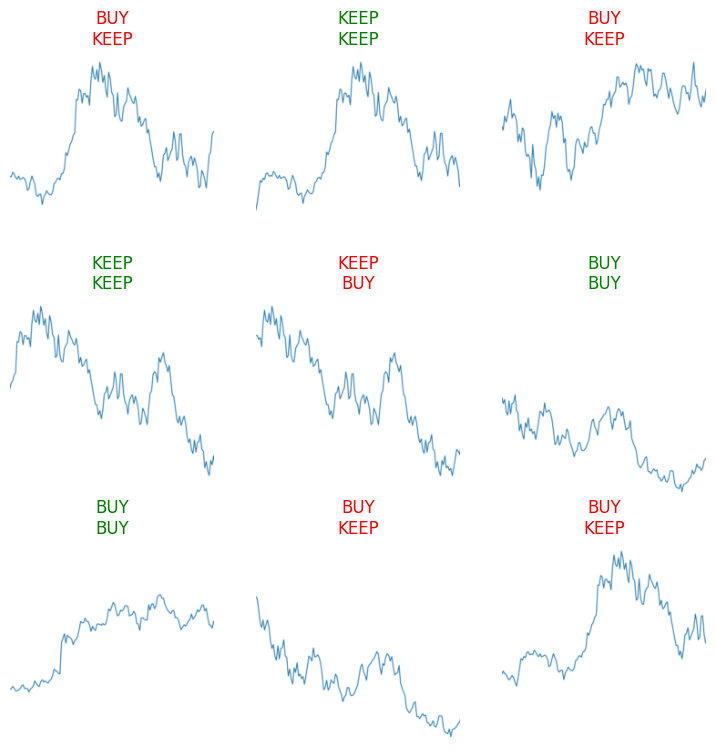

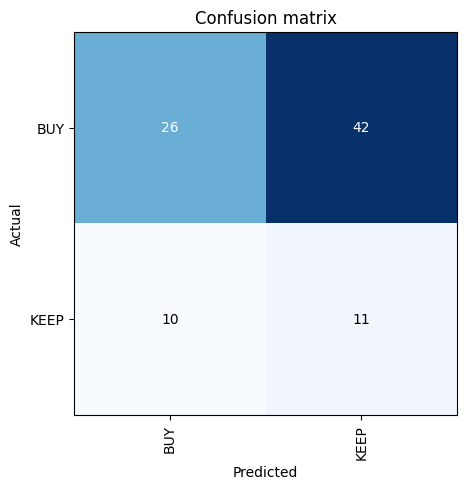

--- PREDICTION FOR LATEST GRAPH ---
File: NVDA_2024-08-27_2025-09-10_BUY.png
Predicted Recommendation: BUY
Probability: 0.7571


In [4]:
!pip install --upgrade fastai --quiet
from fastai.vision.all import *

# 1. Define the DataBlock
# - blocks: Image as input, Category (Buy/Sell/Keep) as output
# - get_items: find all image files recursively
# - splitter: uses the folder names 'train' and 'valid' to split data
# - get_y: parent_label gets the folder name (BUY/SELL/KEEP) as the label
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224) # Ensure all graphs are the same size for the CNN
)

# 2. Load the Data
# Path points to the root directory where /train and /valid are located
dls = dblock.dataloaders(OUT_ROOT_DIR)

# 3. Train the Model
# We'll use ResNet34, a standard robust architecture for image patterns
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(5) # Fine-tune for 5 epochs

# 4. Run Validation Results
# show_results displays actual vs predicted for the validation set
learn.show_results()
plt.show()

# Interpretation: Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
plt.show()

# 5. Run Prediction on the 'pred' folder
# We grab the image file we saved in the /pred directory
pred_files = get_image_files(os.path.join(OUT_ROOT_DIR, "pred"))

if pred_files:
    # Predict the latest graph
    target_img = pred_files[0]
    pred_class, pred_idx, probs = learn.predict(target_img)

    print(f"--- PREDICTION FOR LATEST GRAPH ---")
    print(f"File: {target_img.name}")
    print(f"Predicted Recommendation: {pred_class}")
    print(f"Probability: {probs[pred_idx]:.4f}")
else:
    print("No images found in the pred folder.")